In [1]:
import sys
sys.path.append("../")
import os
from encoding.encoding import encoder
from encoding.fmri_roi_loader import load_roi
import numpy as np
from himalaya.scoring import correlation_score
from himalaya.backend import set_backend
import matplotlib.pyplot as plt
import seaborn as sns
backend = set_backend("torch_cuda", on_error="warn")

In [2]:
resp_path = "/mount/nfs5/matsuyama-takuya/dataset/alg2023"
stim_path = "/mount/nfs5/matsuyama-takuya/dataset/alg2023/features"
save_path = "/mount/nfs5/matsuyama-takuya/dataset/alg2023/results"
model_name = "eva02-clip-enormous"
subjects = [f"subj{str(s).zfill(2)}" for s in range(1, 9)]
use_n_samples = 5000
n_layers = 64
test_split = 0.1

In [3]:
subjects_scores = {}
for sub in subjects:
    # if sub=='subj03':
    #     break
    print(f"Using {sub}'s response data...")
    subjects_scores[sub] = {}
    for hemi in ["lh", "rh"]:
        for layer in range(1, n_layers+1, 4):
            print(f"Extracting features from layer{layer}")
            resp = np.load(f"{resp_path}/{sub}/training_split/training_fmri/{hemi}_training_fmri.npy")
            resp = resp[:use_n_samples]
            print(f"Response shape = {resp.shape}")

            stim = np.load(f"{stim_path}/{model_name}/{sub}/training/layer{layer}.npy")
            stim = stim[:use_n_samples]
            print(f"Stimulus shape = {stim.shape}")

            n_samples_test = int(use_n_samples * test_split)
            n_samples_trn = int(use_n_samples * (1 - test_split))
            resp_trn = resp[:n_samples_trn]
            resp_test = resp[-n_samples_test:]
            print(f"trn_n_samples = {resp_trn.shape[0]}, test_n_samples = {resp_test.shape[0]}")


            flat_stim =stim.reshape(stim.shape[0], -1)
            flat_stim_trn = flat_stim[:n_samples_trn]
            flat_stim_test = flat_stim[-n_samples_test:]

            _, ridge = encoder(flat_stim_trn, resp_trn, return_model=True)
            resp_pred_test = ridge.predict(flat_stim_test)
            scores = correlation_score(resp_test, resp_pred_test)
            scores = backend.to_numpy(scores)
            print(f"Mean test scores: {np.mean(scores)}")

            subjects_scores[sub][layer] = scores

        scores_save_dir = f"{save_path}/{model_name}/scores/"
        os.makedirs(scores_save_dir, exist_ok=True)
        np.save(f"{scores_save_dir}/{hemi}_test_scores.npy", subjects_scores)

Using subj01's response data...
Extracting features from layer1
Response shape = (5000, 19004)


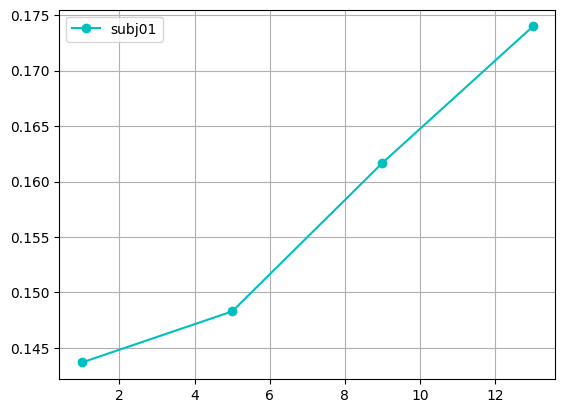

In [12]:
subjects_scores = np.load(f"{scores_save_dir}/test_scores.npy", allow_pickle=True)
subjects_scores = subjects_scores.item()
color_list =['b', 'g', 'r', 'c', 'm', 'y', 'k', '0.5']
fig = plt.figure()
for subname, sub_scores in subjects_scores.items():
    layer_indice = []
    layer_mean_scores = []
    for (layer_index, layer_scores), color in zip(sub_scores.items(), color_list):
        layer_indice.append(layer_index)
        layer_mean_scores.append(np.median(layer_scores))
        
    plt.plot(layer_indice, layer_mean_scores, marker="o", color=color, label=subname)

plt.grid()
plt.legend()
plt.show()
fig_save_path = f"{save_path}/{model_name}/figures"
os.makedirs(fig_save_path, exist_ok=True)
fig.savefig(f"{fig_save_path}/layer_scores.png")

In [17]:
lh_roi_idx

array([    2,     5,    12, ..., 17684, 17685, 17686])

In [45]:

lh_roi.keys()

dict_keys(['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'EBA', 'FBA-1', 'FBA-2', 'mTL-bodies', 'OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces', 'OPA', 'PPA', 'RSC', 'OWFA', 'VWFA-1', 'VWFA-2', 'mfs-words', 'mTL-words', 'early', 'midventral', 'midlateral', 'midparietal', 'ventral', 'lateral', 'parietal'])

In [21]:
lh_scores.item()

{'subj01': {1: array([ 0.49373665,  0.20211644,  0.49731064, ..., -0.07401621,
         -0.14793932,  0.04871239], dtype=float32),
  5: array([ 0.19967496,  0.5761174 ,  0.21586935, ...,  0.21431868,
          0.20453267, -0.12512249], dtype=float32),
  9: array([ 0.2006954 ,  0.45256576,  0.34047365, ...,  0.270303  ,
          0.20921913, -0.01363847], dtype=float32),
  13: array([ 0.21123362,  0.3776499 ,  0.41530266, ...,  0.24024661,
          0.17696357, -0.09763588], dtype=float32)}}

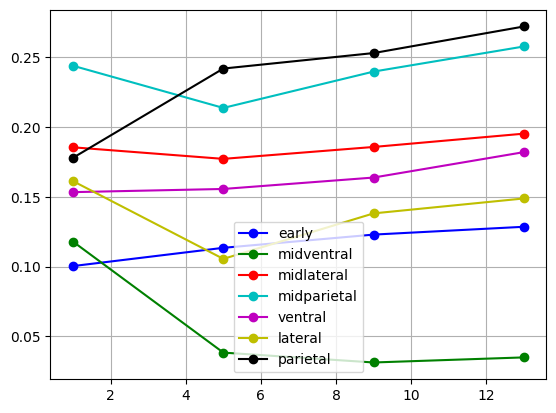

In [47]:
lh_scores = np.load(os.path.join(save_path, model_name, "scores/lh_test_scores.npy"), allow_pickle=True).item()
rh_scores = np.load(os.path.join(save_path, model_name, "scores/rh_test_scores.npy"), allow_pickle=True).item()
roi_name, _ = load_roi(resp_path, 'subj01')
# roi_names = roi_name.keys()
roi_names = ['early', 'midventral', 'midlateral', 'midparietal', 'ventral', 'lateral', 'parietal']
# color_list = sns.hls_palette(len(roi_names), l=.4, s=.8)
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '0.5']
for (roi, color) in zip(roi_names, color_list):
    sub_mean_scores = []
    for sub in subjects:
        lh_roi, rh_roi = load_roi(resp_path, sub)
        lh_roi_idx = lh_roi[roi]
        rh_roi_idx = rh_roi[roi]
        layer_idx_list = []
        layer_scores = []
        for (lh_layer_idx, lh_layer_scores), (rh_layer_idx, rh_layer_scores) in zip(lh_sub_scores.items(), rh_sub_scores.items()):
            layer_idx_list.append(lh_layer_idx)
            both_scores = (np.median(lh_layer_scores[lh_roi_idx]) + np.median(rh_layer_scores[rh_roi_idx])) / 2.0
            layer_scores.append(both_scores)
        layer_scores = np.array(layer_scores)
        sub_mean_scores.append(layer_scores)
    sub_mean_scores = np.array(sub_mean_scores)
    sub_mean_scores = sub_mean_scores.mean(axis=0)
    x = layer_idx_list
    y = sub_mean_scores
    plt.plot(x, y, marker="o", color=color, label=roi)
# plt.xlim([0.8, x.max()+ 1000])
# plt.ylim([-0,1, y.max()+0.1])
plt.grid()
plt.legend()
plt.show()
    

In [34]:


palette = sns.cubehelix_palette(32, start=2, rot=0, dark=0.2, light=0.8, reverse=True)

<function matplotlib.pyplot.show(close=None, block=None)>

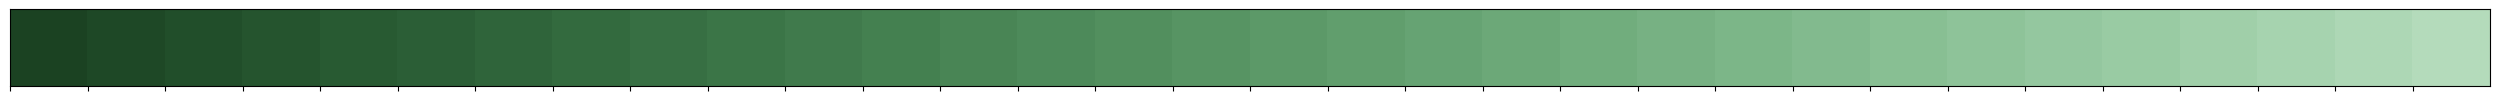

In [37]:
palette
sns.palplot(palette)
plt.show